In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #imbalanced-learn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Step 1 : EDA & Pre-processing

In [6]:
column_types = {
	"customerID": pd.StringDtype(),
	"gender": "category",
	"SeniorCitizen": "category",
	"Partner": "category",
	"Dependents": "category",
	"tenure": "int64",
	"PhoneService": "category",
	"MultipleLines": "category",
	"InternetService": "category",
	"OnlineSecurity": "category",
	"OnlineBackup": "category",
	"DeviceProtection": "category",
	"TechSupport": "category",
	"StreamingTV": "category",
	"StreamingMovies": "category",
	"Contract": "category",
	"PaperlessBilling": "category",
	"PaymentMethod": "category",
	"MonthlyCharges": "float64",
	"TotalCharges": "float64",
	"Churn": "category"
}

pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes

In [7]:

df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv', dtype =column_types, na_values=[' '])
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


I verify if customerID is unique 

In [8]:
# Vérification of the unicity of my column customerID
if df['customerID'].nunique() == len(df): #nunique count the number of unique values
    print("Column 'customerID' has unique values.")
else:
    print("Warning : Column 'customerID' has duplicates.")

Column 'customerID' has unique values.


In [9]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We have 11 missing values for TotalCharges.
Supposition : TotalCharges = Tenure * MonthlyCharges
If so, we can drop the column 

count    7032.000000
mean       45.089157
std        49.899711
min         0.000000
25%         9.437500
50%        28.650000
75%        63.700000
max       373.250000
Name: difference_total_vs_tenure_et_monthlycharges, dtype: float64
Axes(0.125,0.11;0.775x0.77)


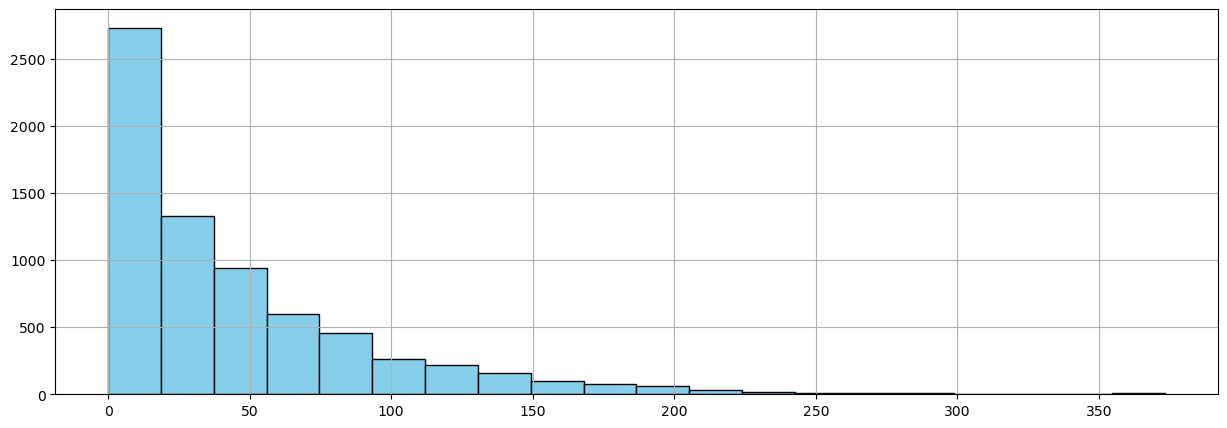

In [10]:
y = pd.DataFrame()
y['difference_total_vs_tenure_et_monthlycharges'] = abs(df['TotalCharges'] - df['tenure'] * df['MonthlyCharges'])
print(y['difference_total_vs_tenure_et_monthlycharges'].describe())
print(y['difference_total_vs_tenure_et_monthlycharges'].hist(bins=20, figsize=(15, 5), color='skyblue', edgecolor='black'))
del y

TotalCharges != tenure * MonthlyCharges 
I won't drop TotalCharges for my model then

In [11]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   string  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [12]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

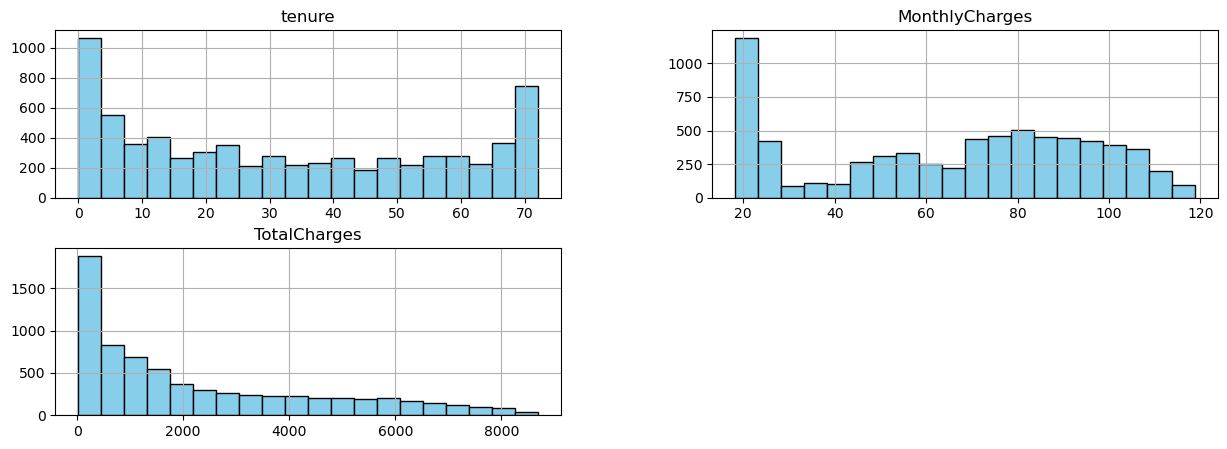

In [13]:
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_columns].hist(bins=20, figsize=(15, 5), color='skyblue', edgecolor='black')


 We also have outliers on the TotalCharges column

In [14]:
categorical_data = df.select_dtypes(include=['category'])
categorical_data.drop(columns=['Churn'], inplace=True)  # Drop the target variable from the categorical data, inplace is to modify and not create a copy
categorical_data

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check
7039,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
7040,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
7041,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


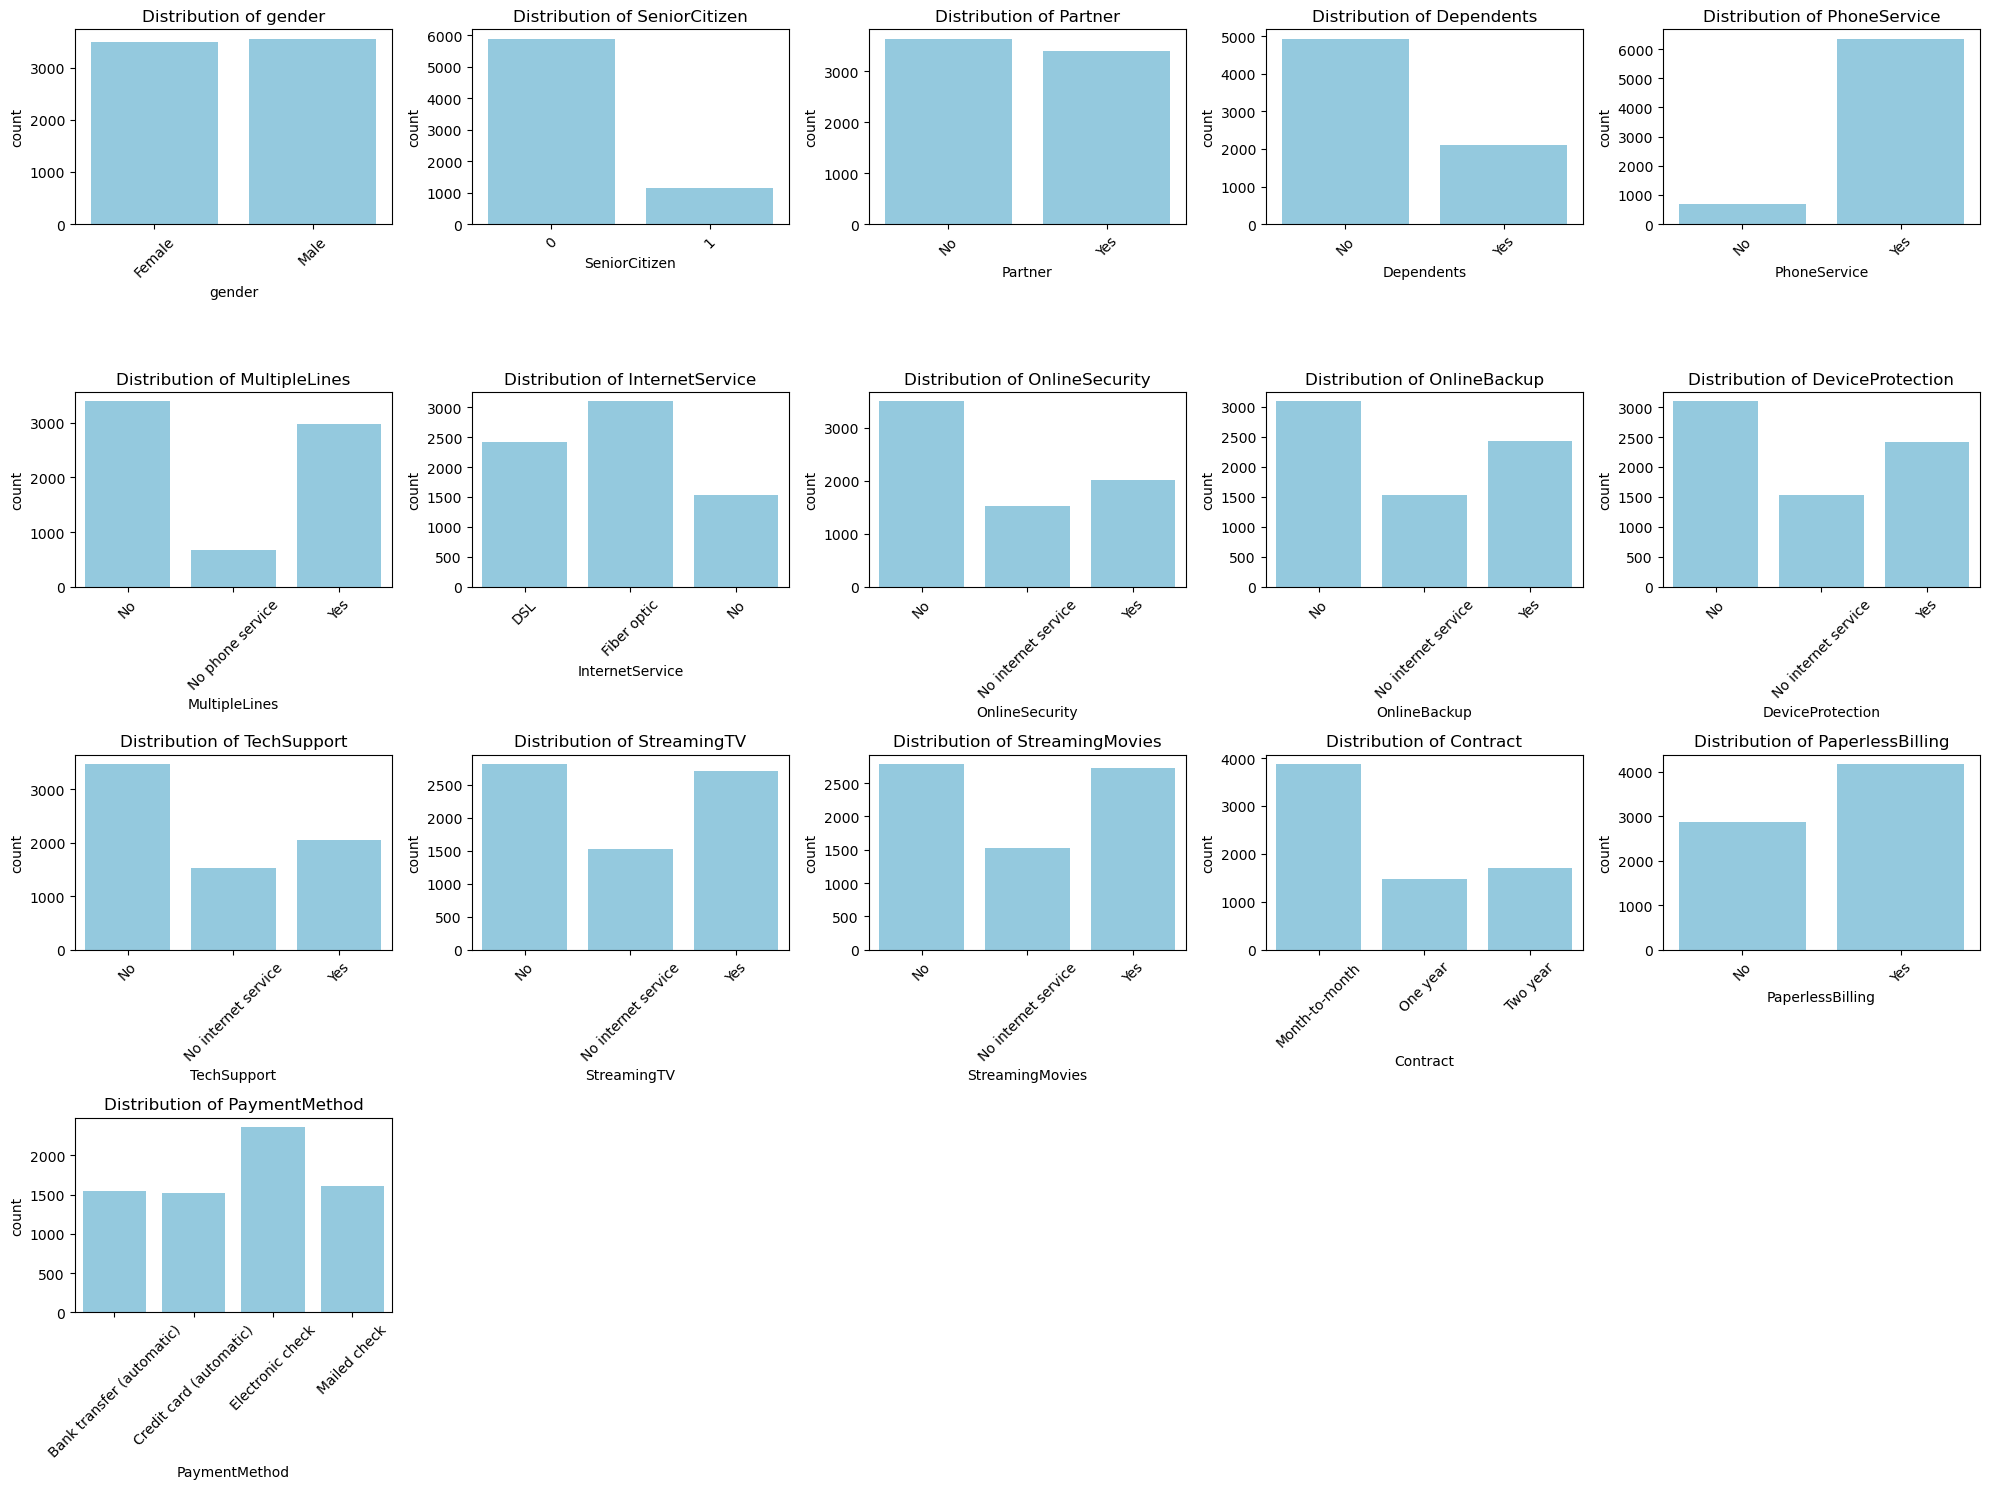

In [15]:

plt.figure(figsize=(20, 15))
i=1
for col in categorical_data.columns:
    # Creates a subplot in a 4x5 grid at position i
    plt.subplot(4, 5, i)
    sns.countplot(data=df, x=col, color='skyblue')
    # Rotates x-axis labels by 45 degrees for better readability
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    i = i+1
# Adjusts the layout to prevent overlap between subplots
plt.tight_layout()

<Axes: xlabel='Churn'>

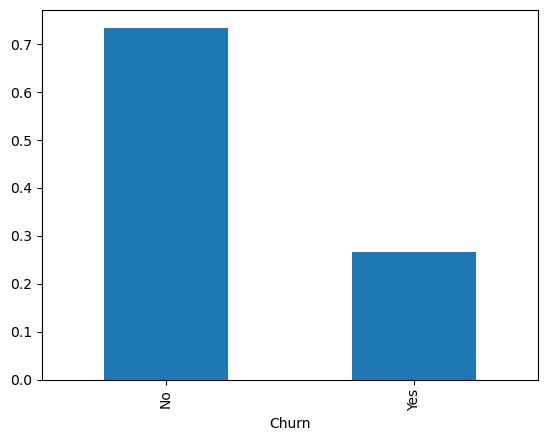

In [16]:
df['Churn'].value_counts(normalize=True).plot(kind='bar')

 We have imbalance in the number of churn in our dataset

<Axes: xlabel='Contract', ylabel='count'>

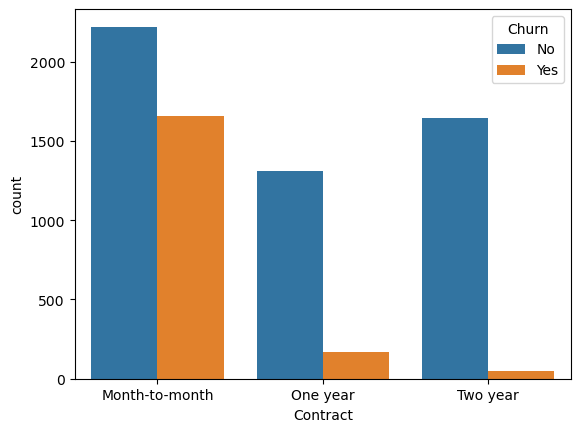

In [17]:
sns.countplot(data=df, x='Contract', hue='Churn')

I'm going to take care of the missing values 
They are not random, so I'm not going to use median/mean, but imputation with these variables : tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup

We're going to see the correlation of our numerical variables
To use the pearson method, we first need to check if the distribution of our variables follow a normal distribution and are linear 

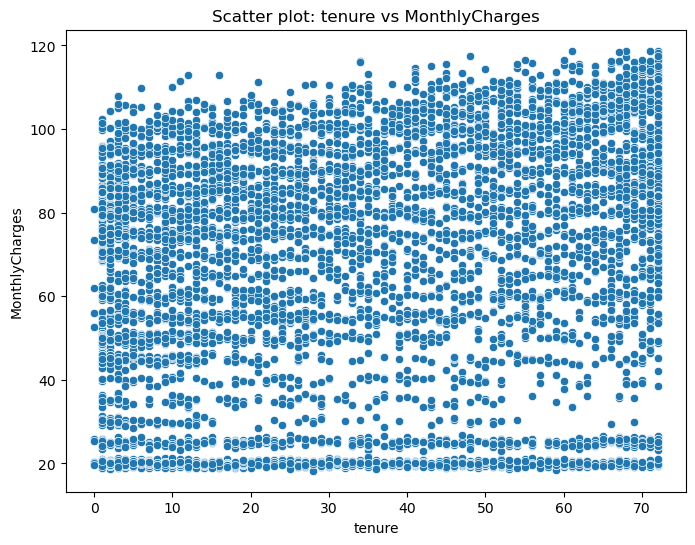

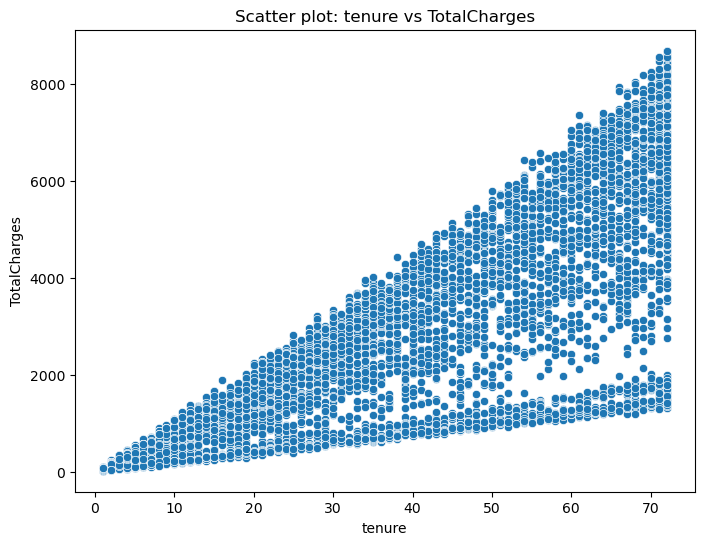

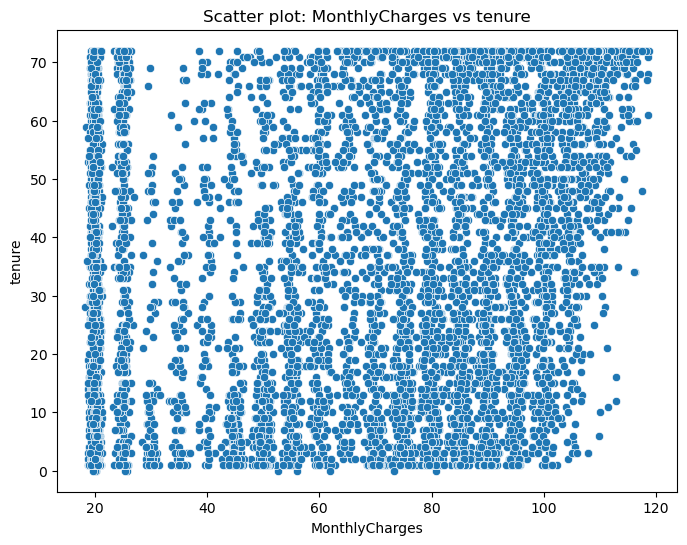

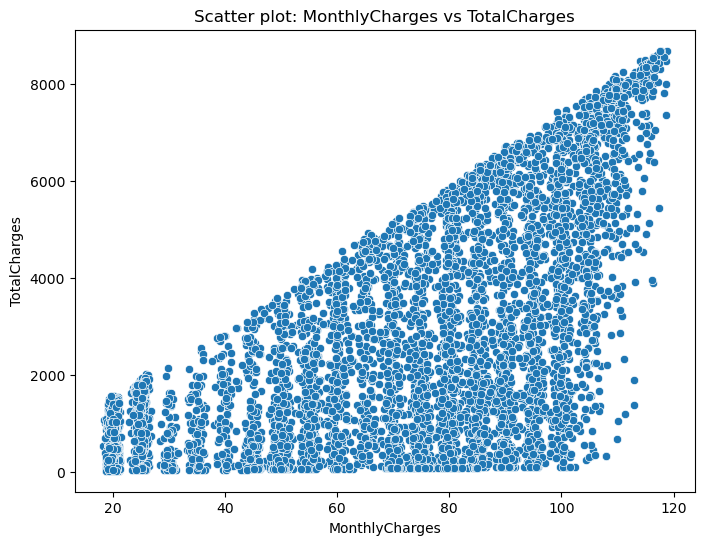

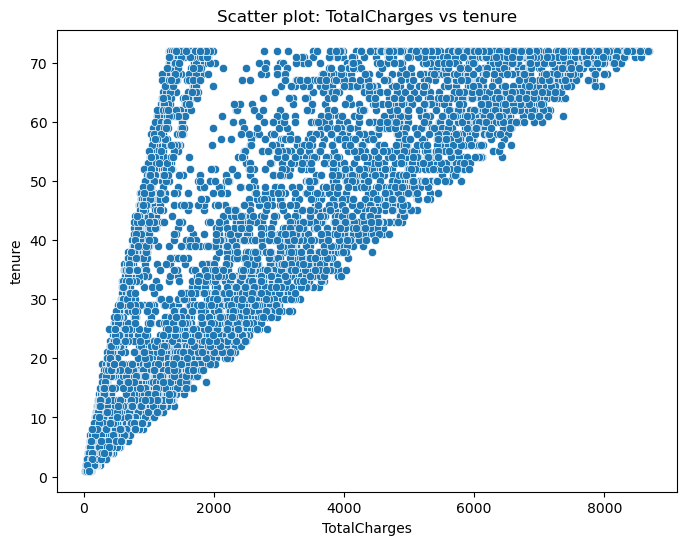

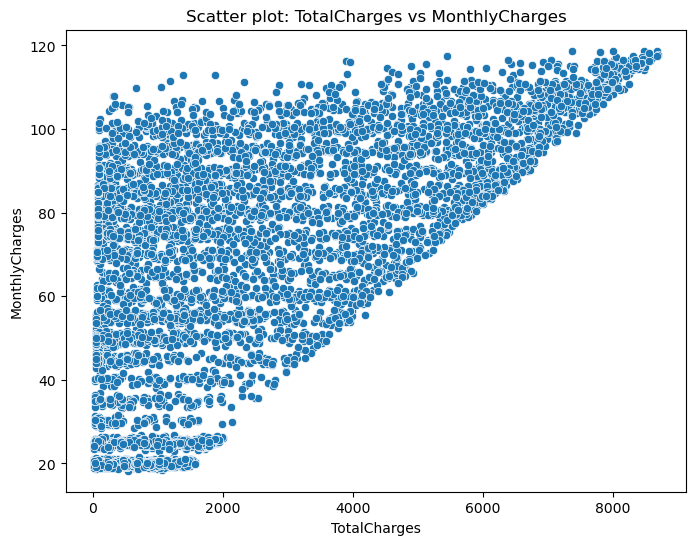

In [18]:
# Vérification de la linéarité
for x in numerical_columns:
    for y in numerical_columns:
        if x != y:  # Avoid plotting a variable against itself
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=x, y=y)
            plt.title(f'Scatter plot: {x} vs {y}')
            plt.show()
# sns.scatterplot(x='x', y='y', data=df[numerical_columns])
# plt.title('Graphique de dispersion')
# plt.show()


Les relations n'ont pas l'air linéaire, on va preferer spearman

In [19]:
matrix_corr = df[numerical_columns].corr(method='spearman')
matrix_corr

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.276417,0.889177
MonthlyCharges,0.276417,1.000000,0.638032
TotalCharges,0.889177,0.638032,1.000000


In [20]:
categorical_data

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check
7039,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
7040,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
7041,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


In [21]:
# Convert categorical columns to string type before encoding, because categorory columns won't accept change to new values 
categorical_data = categorical_data.astype(str)

encoder = OneHotEncoder(sparse_output=False, drop='first') #sparse_output false to have a numpy array as output & drop first to avoid multicollinearity
df_encoded = encoder.fit_transform(categorical_data)

# Get feature/variables names after encoding
categorical_variables_names = encoder.get_feature_names_out(categorical_data.columns)

# Convert to DataFrame for better visualization
df_encoded = pd.DataFrame(df_encoded, columns=categorical_variables_names)

# Concatenate the encoded DataFrame with the numerical variables from the original DataFrame
df_encoded = pd.concat([df[numerical_columns], df_encoded, df['Churn']], axis=1)

df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

df_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,29.85,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,34,56.95,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,2,53.85,108.15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,45,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,2,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1


Imputation : I'm going to use tenure, MonthlyCharges and Contract 
because the only way for the TotalCharges to not be equal to tenure * MonthlyCharges is probably because during the total duration of the relationship between the telecom company and the constumer, there were probably variation in options, contract, resilation then comeback etc... and the only variable catching this is the contract

In [22]:
print(df_encoded.columns)
df_encoded

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
       'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn'],
      dtype='object')


,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,29.85,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,34,56.95,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,2,53.85,108.15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,45,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,2,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
7039,72,103.20,7362.90,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
7040,11,29.60,346.45,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
7041,4,74.40,306.60,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


We're going to use Random Forest for the imputation because 
- handles non linear relationships effectively
- robust to outliers 
- not affected by multicolinearity 
- autoatically captures feature interactions

Number of missing values for TotalCharges : 0

Before imputation:
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64
Axes(0.125,0.11;0.775x0.77)

After imputation:
count    7043.000000
mean     2279.799037
std      2266.730126
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64
Axes(0.125,0.11;0.775x0.77)


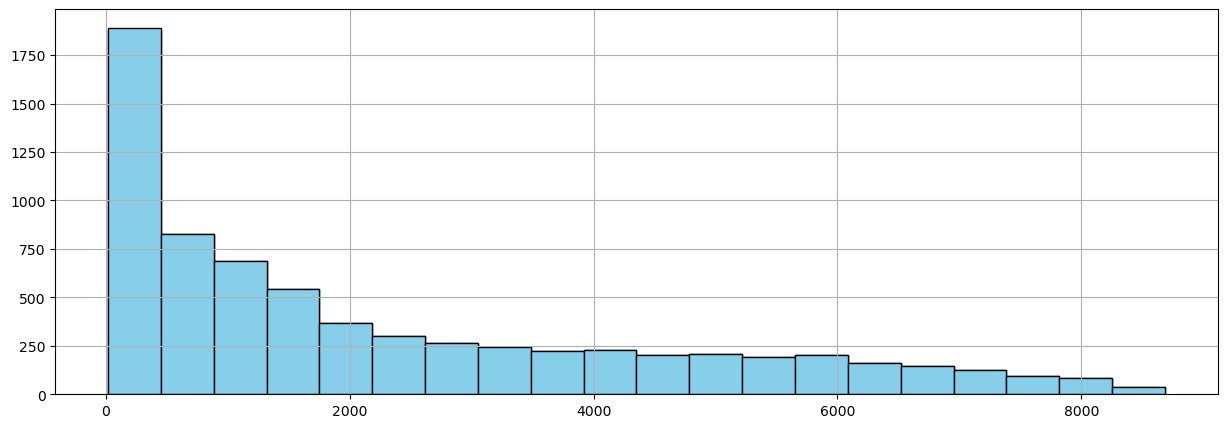

In [23]:
# Training data (with no missing TotalCharges)
x_train = df_encoded.loc[df_encoded['TotalCharges'].notna(), ['tenure', 'MonthlyCharges', 'Contract_Two year', 'Contract_One year']]
y_train = df_encoded.loc[df_encoded['TotalCharges'].notna(), 'TotalCharges']

# Data for prediction (rows with missing TotalCharges)
x_missing = df_encoded.loc[df_encoded['TotalCharges'].isna(), ['tenure', 'MonthlyCharges', 'Contract_Two year', 'Contract_One year']]

# Random Forest model initialisation
forest_model = RandomForestRegressor(n_estimators=100, random_state=221)
forest_model.fit(x_train, y_train)

# Predicting missing TotalCharges values
y_missing = forest_model.predict(x_missing)

# Assigning predicted values to the original DataFrame
df_encoded.loc[df_encoded['TotalCharges'].isna(), 'TotalCharges'] = y_missing 

# Check if there are still missing values in TotalCharges
print(f"Number of missing values for TotalCharges : {df_encoded['TotalCharges'].isna().sum()}")  # Should be 0

# Check the distribution of TotalCharges before imputation
print('\nBefore imputation:')
print(df['TotalCharges'].describe())
print(df['TotalCharges'].hist(bins=20, figsize=(15, 5), color='skyblue', edgecolor='black'))

# Check the distribution of TotalCharges after imputation
print('\nAfter imputation:')
print(df_encoded['TotalCharges'].describe())
print(df_encoded['TotalCharges'].hist(bins=20, figsize=(15, 5), color='skyblue', edgecolor='black'))

count    11.000000
mean     41.447091
std      23.864760
min      19.705000
25%      20.123250
50%      25.734000
75%      58.997250
max      80.855500
Name: difference_total_vs_tenure_et_monthlycharges, dtype: float64
Axes(0.125,0.11;0.775x0.77)


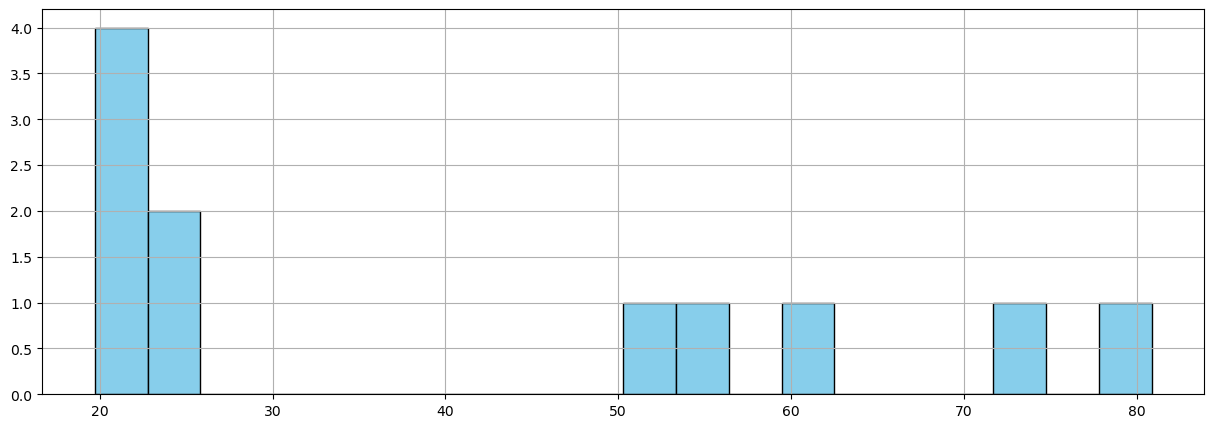

In [24]:
y = pd.DataFrame()
y = df_encoded.loc[df['TotalCharges'].isna(), ['TotalCharges', 'tenure', 'MonthlyCharges']]
y['difference_total_vs_tenure_et_monthlycharges'] = abs(y['TotalCharges'] - y['tenure'] * y['MonthlyCharges'])
print(y['difference_total_vs_tenure_et_monthlycharges'].describe())
print(y['difference_total_vs_tenure_et_monthlycharges'].hist(bins=20, figsize=(15, 5), color='skyblue', edgecolor='black'))
del y

We don't find agregious difference between TotalCharges and tenure*MonthlyCharges, so everything good

In [25]:
df_encoded

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,29.85,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,34,56.95,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,2,53.85,108.15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,45,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,2,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
7039,72,103.20,7362.90,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
7040,11,29.60,346.45,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
7041,4,74.40,306.60,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


Check multicolinearity

In [26]:
# Calculate VIF
X = df_encoded.drop(['Churn'], axis=1) #axis=1 columns / axis=0 rows
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                                variables          VIF
0                                  tenure     7.524952
1                          MonthlyCharges   865.062003
2                            TotalCharges    10.793380
3                             gender_Male     1.002137
4                         SeniorCitizen_1     1.153365
5                             Partner_Yes     1.462702
6                          Dependents_Yes     1.384425
7                        PhoneService_Yes  1770.643139
8          MultipleLines_No phone service    60.867296
9                       MultipleLines_Yes     7.273918
10            InternetService_Fiber optic   148.263379
11                     InternetService_No          inf
12     OnlineSecurity_No internet service          inf
13                     OnlineSecurity_Yes     6.336264
14       OnlineBackup_No internet service          inf
15                       OnlineBackup_Yes     6.782911
16   DeviceProtection_No internet service          inf
17        

c:\Users\mon pc\Desktop\my_data_science_projects\telecom_customer_churn\.conda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


I'm going to drop all the variables that have the information no internet service (except the main one), they cause redundancy

In [27]:
# delete all the column with "No internet service" at the end of their names
X = X.drop(columns=X.filter(regex='No internet service$').columns) #$ means the end of the string
X = X.drop(columns='MultipleLines_No phone service') #$ means the end of the string
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                                variables         VIF
0                                  tenure   20.263027
1                          MonthlyCharges  211.894542
2                            TotalCharges   21.302998
3                             gender_Male    2.021551
4                         SeniorCitizen_1    1.376314
5                             Partner_Yes    2.827184
6                          Dependents_Yes    1.976491
7                        PhoneService_Yes   47.127272
8                       MultipleLines_Yes    2.858621
9             InternetService_Fiber optic   17.668868
10                     InternetService_No    8.234463
11                     OnlineSecurity_Yes    2.685551
12                       OnlineBackup_Yes    2.908271
13                   DeviceProtection_Yes    2.994837
14                        TechSupport_Yes    2.760516
15                        StreamingTV_Yes    4.930343
16                    StreamingMovies_Yes    5.076408
17                      Cont

In [28]:
df_encoded[numerical_columns].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.799037
std,24.559481,30.090047,2266.730126
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [29]:
categorical_columns_encoded = df_encoded.drop(columns=numerical_columns).columns

df_encoded[categorical_columns_encoded].astype('category').describe()


,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
count,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043.0,7043
unique,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2
top,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
freq,3555.0,5901.0,3641.0,4933.0,6361.0,6361.0,4072.0,3947.0,5517.0,5517.0,5024.0,5517.0,4614.0,5517.0,4621.0,5517.0,4999.0,5517.0,4336.0,5517.0,4311.0,5570.0,5348.0,4171.0,5521.0,4678.0,5431.0,5174


In [30]:
correlation = df_encoded[['MonthlyCharges', 'TotalCharges']].corr()
print(correlation)

                MonthlyCharges  TotalCharges
MonthlyCharges        1.000000      0.651182
TotalCharges          0.651182      1.000000


In [31]:
correlation = df_encoded[X.columns].corr(method='spearman')
correlation

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
tenure,1.000000,0.276417,0.889653,0.003486,0.018556,0.384931,0.164175,0.008483,0.337450,0.022490,-0.040604,0.328862,0.360032,0.363329,0.326701,0.284523,0.291002,0.212250,0.544480,0.007695,0.236579,-0.209206,-0.239293
MonthlyCharges,0.276417,1.000000,0.638211,-0.013736,0.221067,0.108463,-0.107011,0.239701,0.521658,0.799117,-0.711107,0.275262,0.435682,0.480255,0.322257,0.642814,0.640252,0.008941,-0.054438,0.345994,0.033042,0.263802,-0.374151
TotalCharges,0.889653,0.638211,1.000000,-0.001495,0.108123,0.340597,0.078805,0.085271,0.469177,0.329059,-0.386861,0.407438,0.489630,0.506820,0.421341,0.494939,0.500567,0.206207,0.341659,0.155116,0.198588,-0.058083,-0.335106
gender_Male,0.003486,-0.013736,-0.001495,1.000000,-0.001874,-0.001808,0.010517,-0.006488,-0.008414,-0.011286,0.006026,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,0.008026,-0.003695,-0.011754,0.001215,0.000752,0.013744
SeniorCitizen_1,0.018556,0.221067,0.108123,-0.001874,1.000000,0.016479,-0.211185,0.008576,0.142948,0.255338,-0.182742,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.046262,-0.117000,0.156530,-0.024135,0.171718,-0.153477
Partner_Yes,0.384931,0.108463,0.340597,-0.001808,0.016479,1.000000,0.452676,0.017706,0.142057,0.000304,0.000615,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.082783,0.248091,-0.014877,0.082029,-0.083852,-0.095125
Dependents_Yes,0.164175,-0.107011,0.078805,0.010517,-0.211185,0.452676,1.000000,-0.001762,-0.024526,-0.165818,0.139812,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,0.068368,0.204613,-0.111377,0.060267,-0.150642,0.059071
PhoneService_Yes,0.008483,0.239701,0.085271,-0.006488,0.008576,0.017706,-0.001762,1.000000,0.279690,0.289999,0.172209,-0.092893,-0.052312,-0.071227,-0.096340,-0.022574,-0.032959,-0.002791,0.003519,0.016505,-0.007721,0.003062,-0.003319
MultipleLines_Yes,0.337450,0.521658,0.469177,-0.008414,0.142948,0.142057,-0.024526,0.279690,1.000000,0.366083,-0.210564,0.098108,0.202237,0.201137,0.100571,0.257152,0.258751,-0.003794,0.106253,0.163530,0.060048,0.083618,-0.227206
InternetService_Fiber optic,0.022490,0.799117,0.329059,-0.011286,0.255338,0.000304,-0.165818,0.289999,0.366083,1.000000,-0.465793,-0.030696,0.165651,0.176049,-0.020492,0.329349,0.322923,-0.076324,-0.211526,0.326853,-0.050077,0.336410,-0.306834


tenure et TotalCharges are correlated but we're going to prefer to keep them both still
We can combine them though

In [32]:
(X['tenure']==0).sum() # Count the number of rows where tenure is 0


11

In [33]:
X = X.loc[df['tenure'] != 0]
X

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,34,56.95,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,53.85,108.15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,45,42.30,1840.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2,70.70,151.65,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
7039,72,103.20,7362.90,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
7040,11,29.60,346.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7041,4,74.40,306.60,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


We calculated the avgmonthlycharges and it's very corrolated to the MonthlyCharges, we're going to drop MonthlyCharges and keep TotalCharges and tenure to keep the information on the seniority of the customer in the company. 
The calculation of avgmonthlycharges help us to see that the missing values of TotalCharges are because it's information on customers that don't have a complete month yet (so we dropped them)

In [34]:
X = X.drop(columns=['MonthlyCharges']) # Drop the MonthlyCharges is not needed anymore

In [35]:
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                                variables        VIF
0                                  tenure  17.073930
1                            TotalCharges  18.028499
2                             gender_Male   1.942509
3                         SeniorCitizen_1   1.366018
4                             Partner_Yes   2.817414
5                          Dependents_Yes   1.961947
6                        PhoneService_Yes   9.277446
7                       MultipleLines_Yes   2.514269
8             InternetService_Fiber optic   4.186492
9                      InternetService_No   3.473225
10                     OnlineSecurity_Yes   1.986701
11                       OnlineBackup_Yes   2.182678
12                   DeviceProtection_Yes   2.299462
13                        TechSupport_Yes   2.099655
14                        StreamingTV_Yes   2.749724
15                    StreamingMovies_Yes   2.771330
16                      Contract_One year   2.056169
17                      Contract_Two year   3.

In [36]:
X[['PhoneService_Yes', 'InternetService_Fiber optic', 'InternetService_No']].astype('category').describe()


,PhoneService_Yes,InternetService_Fiber optic,InternetService_No
count,7032.0,7032.0,7032.0
unique,2.0,2.0,2.0
top,1.0,0.0,0.0
freq,6352.0,3936.0,5512.0


90% of customer have a phone service suscription. I'm going to drop the column, considering it not to be meaningful in this context

In [37]:
X.drop(columns='PhoneService_Yes', inplace=True)

In [38]:
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                                variables        VIF
0                                  tenure  17.023632
1                            TotalCharges  17.996228
2                             gender_Male   1.898851
3                         SeniorCitizen_1   1.365709
4                             Partner_Yes   2.811154
5                          Dependents_Yes   1.954371
6                       MultipleLines_Yes   2.389079
7             InternetService_Fiber optic   3.446509
8                      InternetService_No   2.705974
9                      OnlineSecurity_Yes   1.934705
10                       OnlineBackup_Yes   2.170238
11                   DeviceProtection_Yes   2.295399
12                        TechSupport_Yes   2.057730
13                        StreamingTV_Yes   2.749440
14                    StreamingMovies_Yes   2.771069
15                      Contract_One year   2.052769
16                      Contract_Two year   3.467167
17                   PaperlessBilling_Yes   2.

We know that tenure and TotalCharges are corrolated, we're going to keep them though, because I think that they are important variables
We are going to use the variables from X to train our model, based on the results, we are going to proceed to the feature engeenering

In [39]:
df_filtered_encoded = X.join(df_encoded[['Churn']]) # Join the filtered DataFrame with the target variable
df_filtered_encoded

,tenure,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,34,1889.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,2,108.15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,45,1840.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,2,151.65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
7039,72,7362.90,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
7040,11,346.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
7041,4,306.60,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


# Step 2 : Modelisation & Feature engeneering 

In [40]:
df_filtered_encoded

,tenure,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,34,1889.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,2,108.15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,45,1840.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,2,151.65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
7039,72,7362.90,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
7040,11,346.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
7041,4,306.60,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


We have an imbalance in the target variable and multicolinearity
we're going to prefer a XGboost or Random Forest model 

In [41]:
# Training and Test data
X = df_filtered_encoded.drop(columns='Churn')
y = df_filtered_encoded['Churn']
# Split the data into training and test sets (70% train, 30% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=221, stratify=y) # stratify to keep the same repartition of the target variable in the train and test sets


# Secondary split: validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=221, stratify=y_temp) # stratify to keep the same repartition of the target variable in the train and test sets

del X_temp, y_temp # Delete the temporary variables to free up memory

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training Churn repartirtion:\n", y_train_resampled.astype('category').describe())
print("\nValidation Churn repartirtion:\n", y_val.astype('category').describe())
print("\nTest Churn repartirtion:\n", y_test.astype('category').describe())

# Shape of the data
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Training Churn repartirtion:
 count     7228
unique       2
top          0
freq      3614
Name: Churn, dtype: int64

Validation Churn repartirtion:
 count     1055
unique       2
top          0
freq       774
Name: Churn, dtype: int64

Test Churn repartirtion:
 count     1055
unique       2
top          0
freq       775
Name: Churn, dtype: int64

X_train shape: (4922, 21)
y_train shape: (4922,)
X_val shape: (1055, 21)
y_val shape: (1055,)
X_test shape: (1055, 21)
y_test shape: (1055,)


In [42]:
df_filtered_encoded

,tenure,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,29.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
1,34,1889.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,2,108.15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,45,1840.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,2,151.65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
7039,72,7362.90,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
7040,11,346.45,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
7041,4,306.60,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [43]:
# Random Forest model initialisation
forest_model = RandomForestClassifier(n_estimators=100, random_state=221) 
forest_model.fit(X_train, y_train)

# Predicting Churn values for the validation set
y_val_pred = forest_model.predict(X_val)

y_val_pred_proba = forest_model.predict_proba(X_val)[:, 1]  # For ROC-AUC, Probabilities for the positive class (Churn = 1)
threshold = 0.3
y_val_pred_custom = (y_val_pred_proba >= threshold).astype(int) # Custom threshold for classification
print(f"Custom threshold: {threshold}")

# Calculate metrics if we had a regression problem
#mae_val = mean_absolute_error(y_val, y_val_pred) # same unit as target variable, ideal value close to 0
#mse_val = mean_squared_error(y_val, y_val_pred) # not same unit as target variable, ideal value close to 0
#r2_val = r2_score(y_val, y_val_pred) # ideal value close to 1 = % of variance explained

# Calculate metrics for classification problem

print(classification_report(y_val, y_val_pred_custom, target_names=['No Churn (0)', 'Churn (1)']))
print(f"Confusion matrix : \n{pd.DataFrame(confusion_matrix(y_val, y_val_pred_custom), index=['Actual:0', 'Actual:1'], columns=['Predicted:0', 'Predicted:1'])}")

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba)}")





Custom threshold: 0.3
              precision    recall  f1-score   support

No Churn (0)       0.88      0.77      0.82       774
   Churn (1)       0.53      0.72      0.61       281

    accuracy                           0.76      1055
   macro avg       0.71      0.75      0.72      1055
weighted avg       0.79      0.76      0.77      1055

Confusion matrix : 
          Predicted:0  Predicted:1
Actual:0          595          179
Actual:1           78          203

Validation ROC-AUC: 0.8144937331604549


In [44]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum depth of a tree
    random_state=221,  # For reproducibility
    eval_metric="auc"  # Evaluation metric / "auc" useful for imbalanced dataset
)

# Train the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)

y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class (Churn = 1)
threshold = 0.3
y_val_pred_custom = (y_val_pred_proba >= threshold).astype(int) # Custom threshold for classification
print(f"Custom threshold: {threshold}")

# Evaluate the model
print(classification_report(y_val, y_val_pred_custom, target_names=['No Churn (0)', 'Churn (1)']))
print(f"Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_val, y_val_pred_custom), index=['Actual:0', 'Actual:1'], columns=['Predicted:0', 'Predicted:1'])}")

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba)}")

Custom threshold: 0.3
              precision    recall  f1-score   support

No Churn (0)       0.90      0.78      0.83       774
   Churn (1)       0.55      0.75      0.64       281

    accuracy                           0.77      1055
   macro avg       0.72      0.76      0.73      1055
weighted avg       0.80      0.77      0.78      1055

Confusion Matrix:
          Predicted:0  Predicted:1
Actual:0          603          171
Actual:1           70          211

Validation ROC-AUC: 0.8336781704322878


In [45]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(
    random_state=221,  # For reproducibility
    max_iter=1000,     # Increase iterations if needed
    solver='lbfgs'     # Default solver for small to medium datasets
)

# Train the model on the resampled training data
logistic_model.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = logistic_model.predict(X_val)

y_val_pred_proba = logistic_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class (Churn = 1)
threshold = 0.4
y_val_pred_custom = (y_val_pred_proba >= threshold).astype(int) # Custom threshold for classification
print(f"Custom threshold: {threshold}")

# Evaluate the model
print(classification_report(y_val, y_val_pred_custom, target_names=['No Churn (0)', 'Churn (1)']))
print(f"Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_val, y_val_pred_custom), index=['Actual:0', 'Actual:1'], columns=['Predicted:0', 'Predicted:1'])}")

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba)}")

Custom threshold: 0.4
              precision    recall  f1-score   support

No Churn (0)       0.93      0.66      0.77       774
   Churn (1)       0.48      0.86      0.62       281

    accuracy                           0.71      1055
   macro avg       0.70      0.76      0.69      1055
weighted avg       0.81      0.71      0.73      1055

Confusion Matrix:
          Predicted:0  Predicted:1
Actual:0          511          263
Actual:1           39          242

Validation ROC-AUC: 0.8463497843618675


Seems like a logistic regression is better to predict the churns
I left a multicolinearity issue that wasn't affecting the other models, that I need to correct for a logistic regression

In [46]:
# L1 regularization (Lasso)
# L2 regularization (Ridge)

# Initialize the Logistic Regression model with L2 regularization
logistic_model_l2 = LogisticRegression(
    penalty='l2',          # Use L2 regularization (Ridge)
    random_state=221,      # For reproducibility
    max_iter=1000,          # Increase iterations if needed
    solver='lbfgs'        # Solver that supports L2 regularization
)

# Train the model on the resampled training data
logistic_model_l2.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = logistic_model_l2.predict(X_val)

y_val_pred_proba = logistic_model_l2.predict_proba(X_val)[:, 1]  # Probabilities for the positive class (Churn = 1)
threshold = 0.4
y_val_pred_custom = (y_val_pred_proba >= threshold).astype(int) # Custom threshold for classification
print(f"Custom threshold: {threshold}")

# Evaluate the model
print(classification_report(y_val, y_val_pred_custom, target_names=['No Churn (0)', 'Churn (1)']))
print(f"Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_val, y_val_pred_custom), index=['Actual:0', 'Actual:1'], columns=['Predicted:0', 'Predicted:1'])}")

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba)}")

Custom threshold: 0.4
              precision    recall  f1-score   support

No Churn (0)       0.93      0.66      0.77       774
   Churn (1)       0.48      0.86      0.62       281

    accuracy                           0.71      1055
   macro avg       0.70      0.76      0.69      1055
weighted avg       0.81      0.71      0.73      1055

Confusion Matrix:
          Predicted:0  Predicted:1
Actual:0          511          263
Actual:1           39          242

Validation ROC-AUC: 0.8463497843618675


In [47]:
# Initialize the XGBoost Classifier for logistic regression
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Logistic regression for binary classification
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Maximum depth of a tree
    random_state=221,             # For reproducibility
    eval_metric="logloss"         # Evaluation metric for logistic regression
)

# Train the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)

y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class (Churn = 1)
threshold = 0.5
y_val_pred_custom = (y_val_pred_proba >= threshold).astype(int) # Custom threshold for classification
print(f"Custom threshold: {threshold}")

# Evaluate the model
print(classification_report(y_val, y_val_pred_custom, target_names=['No Churn (0)', 'Churn (1)']))
print(f"Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_val, y_val_pred_custom), index=['Actual:0', 'Actual:1'], columns=['Predicted:0', 'Predicted:1'])}")

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba)}")

Custom threshold: 0.5
              precision    recall  f1-score   support

No Churn (0)       0.85      0.89      0.87       774
   Churn (1)       0.64      0.57      0.60       281

    accuracy                           0.80      1055
   macro avg       0.75      0.73      0.74      1055
weighted avg       0.79      0.80      0.80      1055

Confusion Matrix:
          Predicted:0  Predicted:1
Actual:0          685           89
Actual:1          121          160

Validation ROC-AUC: 0.8336781704322878


Going to keep de logistic regression with L2(ridge) reguralization
We validated the model with the validate dataset, let's test it now with never seen values 

In [48]:
# L1 regularization (Lasso)
# L2 regularization (Ridge)

# Initialize the Logistic Regression model with L2 regularization
logistic_model_l2 = LogisticRegression(
    penalty='l2',          # Use L2 regularization (Ridge)
    random_state=221,      # For reproducibility
    max_iter=1000,          # Increase iterations if needed
    solver='lbfgs'        # Solver that supports L2 regularization
)

# Train the model on the resampled training data
logistic_model_l2.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_test_pred = logistic_model_l2.predict(X_test)

y_test_pred_proba = logistic_model_l2.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Churn = 1)
threshold = 0.4
y_test_pred_custom = (y_test_pred_proba >= threshold).astype(int) # Custom threshold for classification
print(f"Custom threshold: {threshold}")

# Evaluate the model
print(classification_report(y_test, y_test_pred_custom, target_names=['No Churn (0)', 'Churn (1)']))
print(f"Confusion Matrix:\n{pd.DataFrame(confusion_matrix(y_test, y_test_pred_custom), index=['Actual:0', 'Actual:1'], columns=['Predicted:0', 'Predicted:1'])}")

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba)}")

Custom threshold: 0.4
              precision    recall  f1-score   support

No Churn (0)       0.93      0.63      0.75       775
   Churn (1)       0.46      0.86      0.60       280

    accuracy                           0.69      1055
   macro avg       0.69      0.74      0.67      1055
weighted avg       0.80      0.69      0.71      1055

Confusion Matrix:
          Predicted:0  Predicted:1
Actual:0          487          288
Actual:1           39          241

Validation ROC-AUC: 0.8336781704322878


For this problem, in this context, the recall is the most meaningful evaluation
Having 0.86 of churn being capture is very good and 288/775=0.38 of error in the number of people being categorized as churned while not (FPR) is acceptable in this context 

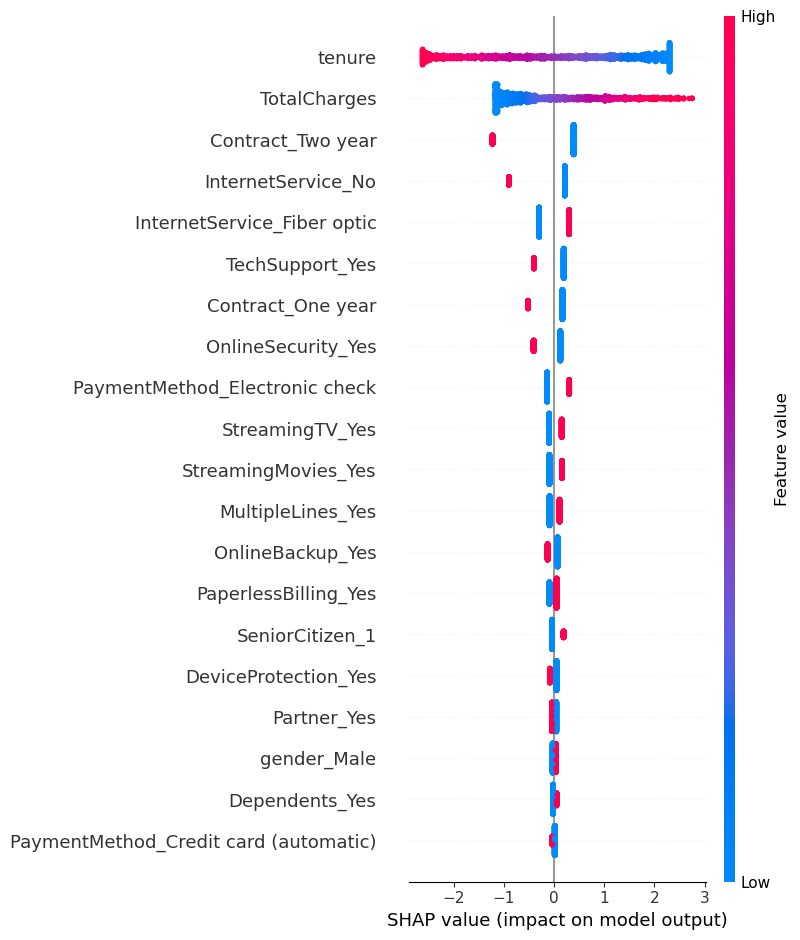

In [49]:
import shap
explainer = shap.Explainer(logistic_model_l2, X_test)

shap_values = explainer(X_test)

# Visualize global feature importance
shap.summary_plot(shap_values.values, X_test)